<a href="https://www.kaggle.com/code/yoonjunggyu/stable-diffusion-generated-image-downloader?scriptVersionId=159678789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

This is a kaggle notebook that automatically generates and downloads AI images you want. This is using Random Prompt method to make variant images.

## Feature

1. Automatic image generation feature tailored to user preferences.
2. Supports Image Variation and Upscaling features.
3. Download all generated images at once in a compressed file.

<hr>

## How to Run

### 1. Click Copy & Edit

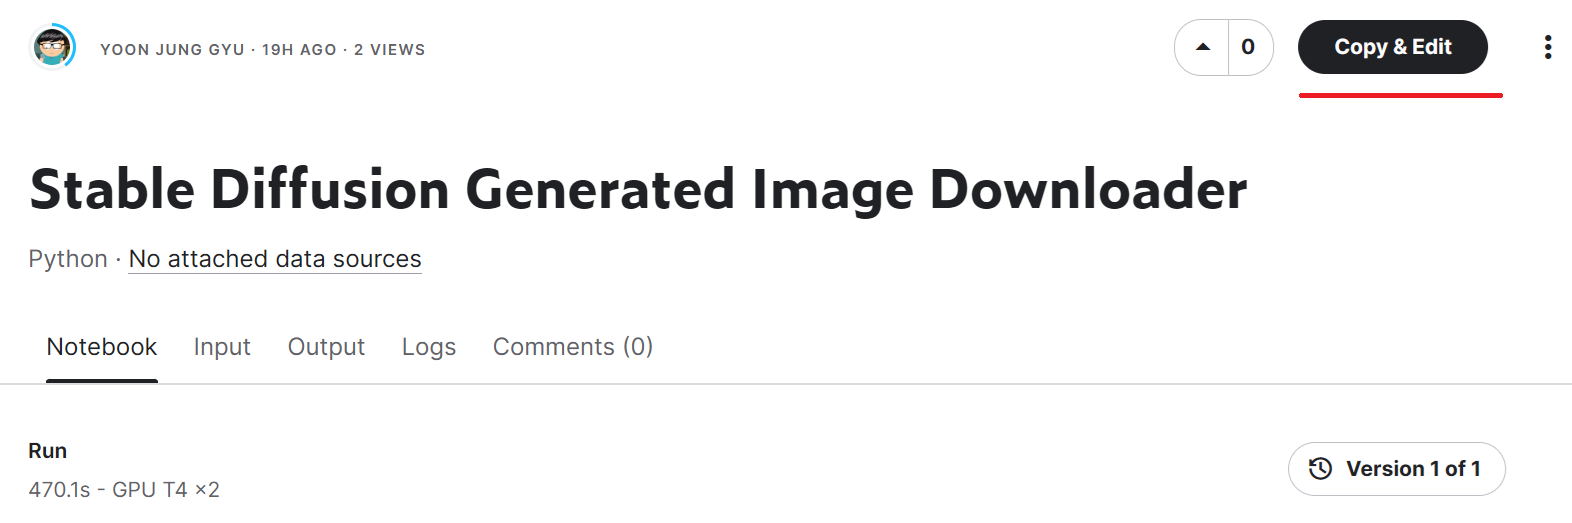

### 2. Go to copied notebook

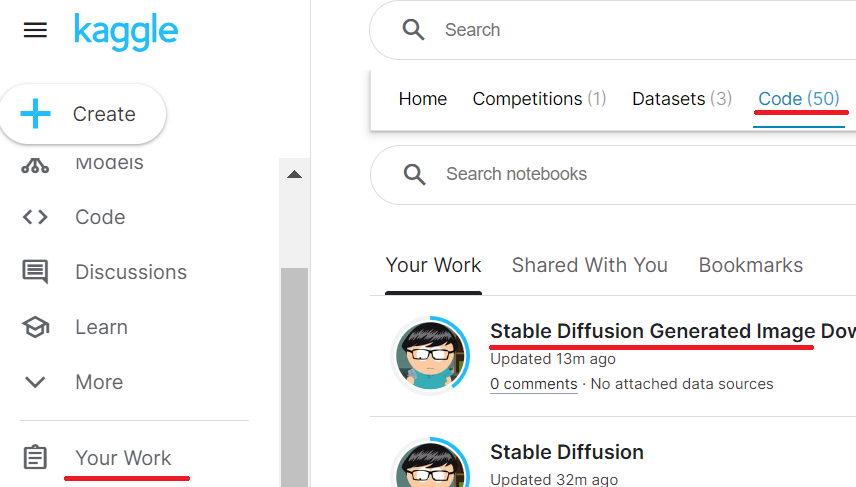

### 3. Setting Notebook options properly 

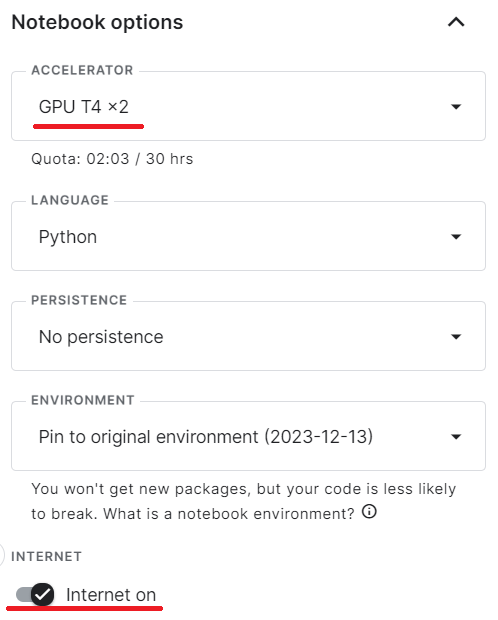

### 4. Modify variables (look at the "Parameters & Variables" section below)

### 5. Press "Run All"

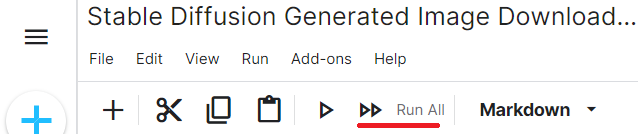

### 6. Download images

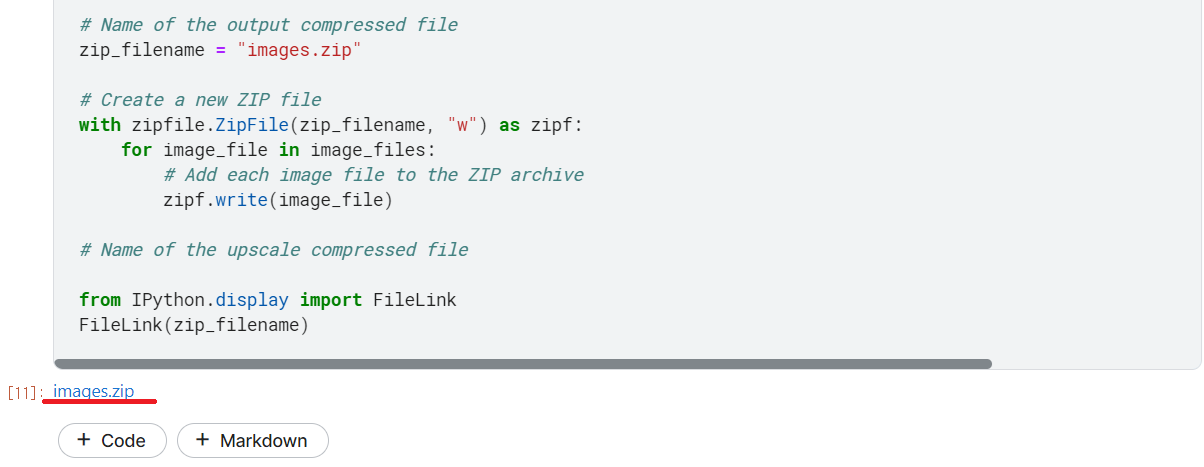

### 7. If you want to generate additional images, run "Generating the Image" section. After that, you can download them.

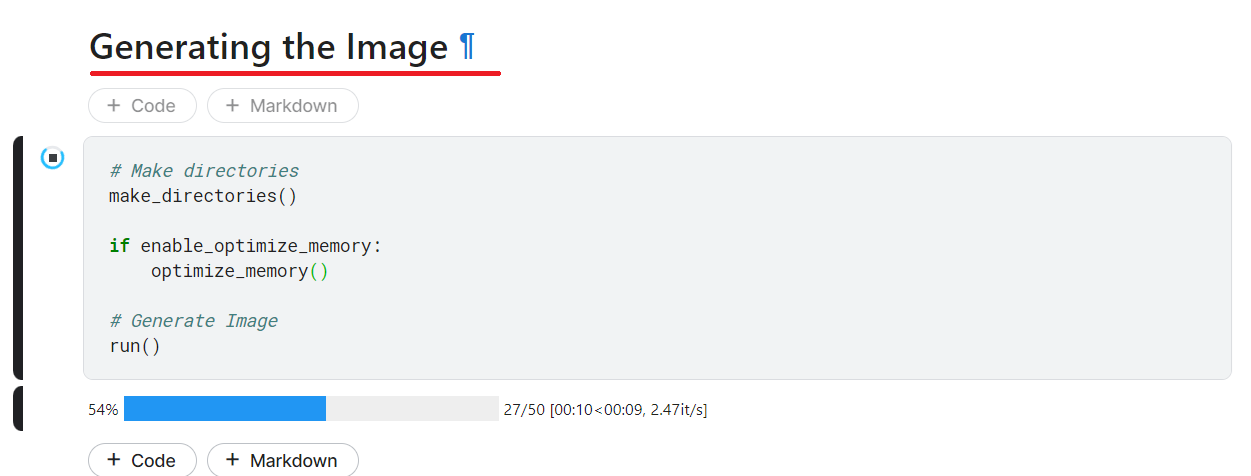

### 8. If you want to remove previous images you generated, run "Remove" section.

## Note
1. **What is the 'Random Prompt' Method?**
   - In the automatic image generation process, the 'Random Prompt' method creates a random prompt for each loop, combining the words you have written. This allows you to generate a variety of images without manually entering prompts, even while you are busy with other tasks.
   

2. **Kaggle's GPU Policy**
   - According to Kaggle's policy, there is a limit of 30 hours per week for GPU usage. Remember to shut down your notebook when it's not in use.

## Support

If you would like to support this project, you can click the button below to make a donation. Your contribution will greatly assist this project!

<a href="https://www.buymeacoffee.com/yjg30737" target="_blank"><img src="https://cdn.buymeacoffee.com/buttons/v2/default-yellow.png" alt="Buy Me A Coffee" style="height: 60px !important;width: 217px !important;" ></a>

## Contact
Please share with me any good models or prompts for my project on <a href="https://github.com/yjg30737/stable-diffusion-generated-image-downloader">GitHub</a>!

I will update them on my notebook as soon as possible.

Don't forget to press the button below!

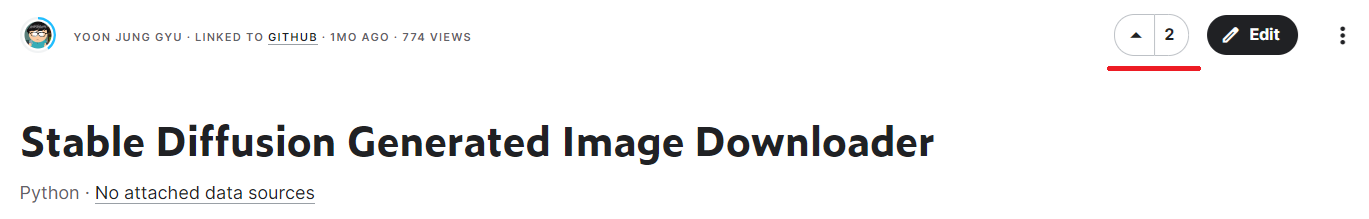

# Download necessary packages

In [1]:
# For image generation
!pip3 install diffusers
!pip3 install accelerate --upgrade

# For image upscaling
!git clone https://github.com/TencentARC/GFPGAN.git

# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip3 install basicsr

# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip3 install facexlib

!pip3 install -r GFPGAN/requirements.txt
!python GFPGAN/setup.py develop

# If you want to enhance the background (non-face) regions with Real-ESRGAN,
# you also need to install the realesrgan package
!pip3 install realesrgan

!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/e4/c6/1f9768606c937e71c4d391307f395942c42d5567f538712dbf37b0cc0917/diffusers-0.25.1-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.20.2 from https://files.pythonhosted.org/packages/3d/0a/aed3253a9ce63d9c90829b1d36bc44ad966499ff4f5827309099c8c9184b/huggingface_hub-0.20.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/a6/b9/44623bdb05595481107153182e7f4b9f2ef9d3b674938ad13842054dcbd8/accelerate-0.26.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━

# Import modules

In [2]:
import os
import gc
import os
import math
import random
import string
import torch
import subprocess

from PIL import Image
from diffusers import DiffusionPipeline, StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler
from huggingface_hub import list_files_info

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Parameters & Variables

## Description of Each Variable

You can change each variable to generate the image you desire.

1. **Variable Name**: `original_prompt`
   - **Description**: This is the base prompt used for generating images. It defines the general attributes of the desired image.
   - **Example Usage**: "If `original_prompt` includes 'beautiful landscape', the AI will generate images of picturesque natural scenes."


2. **Variable Name**: `negative_prompt`
   - **Description**: This is used to specify what should not be included in the image, helping to avoid undesired elements.
   - **Example Usage**: "Setting `negative_prompt` to include 'no animals' ensures the image generation process avoids animal depictions."


3. **Variable Name**: `width` and `height`
   - **Description**: These define the dimensions of the generated image.
   - **Example Usage**: "If `width` is 1024 and `height` is 768, the generated image will have a resolution of 1024x768 pixels."


4. **Variable Name**: `num_inference_steps`
   - **Description**: This determines how many steps the AI takes in generating the image, affecting the detail and quality.
   - **Example Usage**: "A higher `num_inference_steps` value might result in a more detailed image."


5. **Variable Name**: `guidance_scale`
   - **Description**: This influences how closely the AI follows the prompt, with a higher value leading to more literal interpretations.
   - **Example Usage**: "Setting `guidance_scale` to 10 will make the AI adhere more strictly to the provided prompt."


6. **Variable Name**: `rows` and `cols`
   - **Description**: These determine the layout of the image grid in the output.
   - **Example Usage**: "Setting `rows` to 2 and `cols` to 3 creates a grid of 6 images."


7. **Variable Name**: `model_id`
   - **Description**: Specifies the AI model used for image generation. Different models have different styles or specializations.
   - **Example Usage**: "Using `model_id` 'Linaqruf/anything-v3.0' is suitable for generating anime-style images."


8. **Variable Name**: `loop_n`
   - **Description**: Determines how many times the image generation process will loop.
   - **Example Usage**: "If `loop_n` is set to 5, the AI will generate images five times, potentially creating different variations each time."


9. **Variable Name**: `randomize`
   - **Description**: A boolean variable that, when set to True, enables random variations in the image generation process.
   - **Example Usage**: "Setting `randomize` to True allows for unexpected and diverse image results."

10. **Variable Name**: `run_variation`
    - **Description**: When set to True, this enables the generation of multiple variations of the image.
    - **Example Usage**: "Enabling `run_variation` can produce different artistic interpretations of the same base prompt."


11. **Variable Name**: `run_upscaling`
    - **Description**: Determines whether to upscale the generated image to a higher resolution.
    - **Example Usage**: "Setting `run_upscaling` to True enhances the image's resolution and clarity."


12. **Variable Name**: `enable_optimize_memory`
    - **Description**: This option, when activated, optimizes memory usage but might reduce performance.
    - **Example Usage**: "If you are experiencing system lag, set `enable_optimize_memory` to True to reduce memory usage."


13. **Variable Name**: `var_images_n`
    - **Description**: Specifies the number of image variations to generate.
    - **Example Usage**: "A `var_images_n` value of 3 will result in three different versions of the prompted image."


14. **Variable Name**: `upsample_scale`
    - **Description**: Determines the scaling factor for upscaling the image. A higher value results in a larger image.
    - **Example Usage**: "If `upsample_scale` is 4, the image will be upscaled to four times its original size." 

In [3]:
# Random prompt attributes
# '' means blank, which increases the possibility of usual output
hair_color_randomizer = ['', 'blonde hair', 'red hair', 'blue hair', 'dark hair', 'green hair', 'white hair']
hair_style_randomizer = ['Long straight hair', 'Short pixie cut', 'Bob haircut', 'Layered haircut', 'Curly hair', 'Wavy hair', 'Ponytail', 'Messy bun', 'French braid', 'Dutch braid', 'Fishtail braid', 'High bun', 'Low bun', 'Top knot', 'Half-up half-down hairstyle', 'Braided crown', 'Side-swept bangs', 'Bangs/fringe', 'Chignon', 'Waterfall braid', 'Mohawk', 'Beach waves', 'Updo', 'French twist', 'Cornrows', 'Dreadlocks', 'Pigtails', 'Space buns', 'Sock bun']
clothes_randomizer = ['wearing denim jacket', 'wearing coat', 'wearing blazer', 'wearing blouse', 'wearing biker clothes', 'wearing distressed jeans', 'wearing hoodie']
expression_randomizer = ['Smile', 'Grin', 'Closed eyes', 'Squinting', '(laughing:1.2)', '(giggle:1.2)', '(Angry face:1.4)', 'Frowning face', 'Confused face', 'Boredom', 'Eyebrow furrow', 'Eye roll', 'Smirk']
pose_randomizer = ['', '', 'sitting', 'lying', 'leaning', 'cross-legged']
camera_distance_randomizer = ['', '', '(extreme close-up:1.5)', '(medium full shot:1.5)', '(close-up:1.5)', '(establishing shot:1.5)', '(medium close-up:1.5)', '(point-of-view:1.5)', '(medium shot:1.5)', '(cowboy shot:1.5)', '(long shot:1.5)', '(upper body:1.5)', '(full shot:1.5)', '(full body:1.5)']
camera_angle_randomizer = ['', '', '(front view:1.5)', '(from below:1.5)', '(bilaterally symmetrical:1.5)', '(from behind:1.5)', '(side view:1.5)', '(wide angle view:1.5)', '(back view:1.5)', '(fisheyes view:1.5)',
                           '(from above:1.5)', '(macro view:1.5)',
                           '(overhead shot:1.5)', '(straight on:1.5)', '(top down view:1.5)', '(hero view:1.5)',
                           "(bird's eye view:1.5)", '(low view:1.5)', '(high angle:1.5)',
                           "(worm's eye view:1.5)", '(slightly above:1.5)', '(selfie:1.5)']

adding_lighting_randomizer = ['', 'bloom', 'backlight', 'sun light', 'soft lighting', 'god rays', 'studio light', 'hard lighting', 'volumetic lighting', 'bioluminescent light']
wind_randomizer = ['', '(wind:0)', '(wind:0.5)', '(wind:1)', '(wind:1.5)', '(wind:2)']
acc1_randomizer = ['', 'wearing sunglasses', 'tattoo']
acc3_randomizer = ['', '', 'wearing beanie', 'wearing beret', 'wearing cap', 'wearing fedora']
attr2_randomizer = ['', 'put on earphones', 'piercing on nose', 'put on headphones']
location_randomizer = ['in the office', 'Tokyo street', 'In the living room', 'In the music studio', 'On the beach', 'In the club']

randomizer_arr = [
    hair_color_randomizer,
    hair_style_randomizer,
    clothes_randomizer,
    expression_randomizer,
    pose_randomizer,
    camera_distance_randomizer,
    camera_angle_randomizer,
    adding_lighting_randomizer,
    wind_randomizer,
    acc1_randomizer,
]

# Prompt
# Each values below are by default, you can change this to whatever you want. 
# This is generally acceptable if you want to make image of woman.
original_prompt = "masterpiece, best quality, high resolution, 8K, HDR, beautiful girl, detailed hair, beautiful face, ultra detailed eyes, (hyperdetailed:1.15)"
negative_prompt = "EasyNegative, (low quality, worst quality:1.4), (bad anatomy), (inaccurate limb:1.2), bad composition, inaccurate eyes, extra digit, fewer digits, (extra arms:1.2)"

# Other parameters
width = 768
height = 768
num_inference_steps = 50
guidance_scale = 7.5

# Image grid
# If you set rows to 2, cols to 2, this will generate 2x2 images. 
rows = 1
cols = 1
num_images_per_prompt = rows*cols

# Model to use (example)
model_id = "Linaqruf/anything-v3.0" # Good for anime
# model_id = "SG161222/Realistic_Vision_V1.4" # Good for realistic human, celebrity
# model_id = "dreamlike-art/dreamlike-photoreal-2.0" # Anything

# Find the model you want in link below:
# https://huggingface.co/models?pipeline_tag=text-to-image&sort=trending

# Set how many times you want to loop the generating image process
loop_n = 3

# Set True or False whether you want to do
# Randomize prompt
randomize = True
# Image variation
run_variation = True
# Upscaling image
run_upscaling = True
# Opimize memory (Less memory, less performance)
enable_optimize_memory = False

# Image variation - Amount of images you want to make
var_images_n = 4

# Upscaling - Upsampling scale
upsample_scale = 2

# Do not change the following variables

In [4]:
prompt = f"{original_prompt}"
    
root_path = 'result'
default_path = os.path.join(root_path, 'default')
variation_path = os.path.join(root_path, 'variation')
upscaling_path = os.path.join(root_path, 'upscaling')
upscaling_img_download_path = os.path.join(upscaling_path, 'restored_imgs')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = torch.Generator(device=device)

# Functions

In [5]:
def generate_random_prompt(arr):
    if len(arr) > 0:
        max_len = max(map(lambda x: len(x), arr))
        weights = [i for i in range(max_len, 0, -1)]
        random_prompt = ', '.join(list(filter(lambda x: x != '', [random.choices(_, weights[:len(_)])[0] for _ in arr])))
    else:
        random_prompt = ''
    return random_prompt

def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()
    
# For avoiding token limits of prompt
        
def forward_embeddings_through_text_encoder(pipeline, common_args):
    max_length = pipeline.tokenizer.model_max_length

    input_ids = pipeline.tokenizer(common_args['prompt'], return_tensors="pt").input_ids
    input_ids = input_ids.to("cuda")
    
    common_args['prompt_embeds'] = ''
    common_args['negative_prompt_embeds'] = ''
    
    
    if input_ids.shape[1] > max_length:
        negative_ids = pipeline.tokenizer(common_args['negative_prompt'], truncation=False, padding="max_length", max_length=input_ids.shape[-1], return_tensors="pt").input_ids                                                                                                     
        negative_ids = negative_ids.to("cuda")
        
        concat_embeds = []
        neg_embeds = []
        for i in range(0, input_ids.shape[-1], max_length):
            concat_embeds.append(pipeline.text_encoder(input_ids[:, i: i + max_length])[0])
            neg_embeds.append(pipeline.text_encoder(negative_ids[:, i: i + max_length])[0])

        prompt_embeds = torch.cat(concat_embeds, dim=1)
        negative_prompt_embeds = torch.cat(neg_embeds, dim=1)
        
        if prompt_embeds.shape[1] < negative_prompt_embeds.shape[1]: 
            padding = (0, 0, 0, negative_prompt_embeds.shape[1] - prompt_embeds.shape[1], 0, 0)
            prompt_embeds = F.pad(prompt_embeds, padding)
        
        del common_args['prompt']
        del common_args['negative_prompt']
        
        common_args['prompt_embeds'] = prompt_embeds
        common_args['negative_prompt_embeds'] = negative_prompt_embeds
    else:
        del common_args['prompt_embeds']
        del common_args['negative_prompt_embeds']
        
    return common_args

def image_to_grid(images, rows, cols):
    assert len(images) == rows * cols

    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def generate_image(pipeline, **args):
    # Clear cache to avoid OutOfMemoryError
    clear_cache()

    images = pipeline(**args).images
    return images

def generate_random_string(length):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for _ in range(length))

def get_filename(prompt, cnt, ext, width, height, model_id, suffix=''):
    # Replace slash with lowdash from model_id
    model_id = model_id.replace('/', '_')
    return f"{'_'.join(map(lambda x: x.replace(',', ''), prompt.split()[:cnt]))}({width}x{height})-{model_id}_{suffix}{ext}"

def save_images(images, prompt, model_id, ext='.png', save_path='.', suffix=''):
    for i in range(len(images)):
        img = images[i]
        filename = os.path.join(save_path, get_filename(prompt, 10, ext, width=img.width, height=img.height, model_id=model_id,
                                                        suffix=(suffix if suffix == '' else suffix+'_')+generate_random_string(10)))
        img.save(filename)
        
# Make directories
def make_directories():
    os.makedirs(root_path, exist_ok=True)
    os.makedirs(default_path, exist_ok=True)
    os.makedirs(variation_path, exist_ok=True)
    os.makedirs(upscaling_img_download_path, exist_ok=True)

# Run the image generation process
def run():
    common_args = {
        'width': width,
        'height': height,
        'prompt': '',
        'negative_prompt': '',
        'num_inference_steps': num_inference_steps,
        'guidance_scale': guidance_scale,
        'num_images_per_prompt': num_images_per_prompt
    }
    
    for _ in range(loop_n):
        # Initialize prompt in each loop
        prompt = f"{original_prompt}"
        if randomize:
            prompt += f", {generate_random_prompt(randomizer_arr)}"
        common_args['negative_prompt'] = negative_prompt
        common_args['prompt'] = prompt

        # Forward embeddings and negative embeddings through text encoder
        # If token indices sequence length is longer than the specified maximum sequence length for this model, this will be applied
        common_args = forward_embeddings_through_text_encoder(pipeline, common_args)
        images = generate_image(pipeline, **common_args)

        if len(images) > 1:
            grid = image_to_grid(images, rows=rows, cols=cols)
            suffix = f'({rows}x{cols} grid)'
            save_images([grid], prompt=prompt, model_id=model_id, suffix=suffix, save_path=default_path)
        else:
            save_images(images, prompt=prompt, model_id=model_id, save_path=default_path)

        # Variation
        if run_variation:
            make_variation(images, var_images_n, var_pipeline, common_args)

    # Upscaling
    if run_upscaling:
        make_upscaling(upsample_scale)
        
# Variation
def make_variation(images, n, var_pipeline, common_args):
    for _ in range(n):
        seed = math.floor(random.random() * 10000000)
        variation_args = {
            **common_args,
            "image": images[0],
            "strength": 0.7,
            "generator": generator,
        }
        images = generate_image(var_pipeline, **variation_args)
        suffix = f'{n}' + '' if common_args.get('seed', '') else f'({seed})'
        save_images(images, prompt=prompt, model_id=model_id, suffix=suffix, save_path=variation_path)
        
# Optimizing memory
def optimize_memory():
    pipeline.enable_model_cpu_offload()
        
# Upscaling
def make_upscaling(upsampling_scale=2):
    cmd = f'python GFPGAN/inference_gfpgan.py -i {default_path} -o {upscaling_path} -v 1.3 -s {upsampling_scale}'
    subprocess.run(cmd.split(' '))
        
# Not using now
# def get_info(lora_path):
#     return [info.rfilename for info in list_files_info(lora_path) if info.lfs is not None]

# def load_lora_weights(pipeline, lora_path):
#     weight_name = get_info(lora_path)[0]
#     pipeline.load_lora_weights(lora_path, weight_name=weight_name)

# Load model

In [6]:
# Clear cache to avoid OutOfMemoryError 1
clear_cache()

# Load model for image generation
pipeline = DiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, safety_checker=None
).to(device)

# Set scheduler to model
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config, use_karras_sigmas=True
)

# Clear cache to avoid OutOfMemoryError 2
clear_cache()

# Load model for image variation
var_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, cache_dir='models', torch_dtype=torch.float16, safety_checker=None 
).to(device)

# Clear cache to avoid OutOfMemoryError 3
clear_cache()

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

# Generating the Image

In [7]:
# Make directories
make_directories()

if enable_optimize_memory:
    optimize_memory()

# Generate Image
run()

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth" to /opt/conda/lib/python3.10/site-packages/weights/RealESRGAN_x2plus.pth



100%|██████████| 64.0M/64.0M [00:00<00:00, 251MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /kaggle/working/gfpgan/weights/detection_Resnet50_Final.pth



100%|██████████| 104M/104M [00:00<00:00, 245MB/s] 


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth" to /kaggle/working/gfpgan/weights/parsing_parsenet.pth



100%|██████████| 81.4M/81.4M [00:00<00:00, 259MB/s]


Processing masterpiece_best_quality_high_resolution_8K_HDR_beautiful_girl_detailed(768x768)-Linaqruf_anything-v3.0_A1Sr2XlTDI.png ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing masterpiece_best_quality_high_resolution_8K_HDR_beautiful_girl_detailed(768x768)-Linaqruf_anything-v3.0_QFIqZf9erU.png ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing masterpiece_best_quality_high_resolution_8K_HDR_beautiful_girl_detailed(768x768)-Linaqruf_anything-v3.0_fUq2ofD7kJ.png ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Results are in the [result/upscaling] folder.


# Download

In [8]:
import os
import zipfile

# List of image files to be added to the compressed file
image_files = [os.path.join(default_path, filename) for filename in os.listdir(default_path)]
image_files.extend([os.path.join(variation_path, filename) for filename in os.listdir(variation_path)])
image_files.extend([os.path.join(upscaling_img_download_path, filename) for filename in os.listdir(upscaling_img_download_path)])

# Name of the output compressed file
zip_filename = "images.zip"

# Create a new ZIP file
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for image_file in image_files:
        # Add each image file to the ZIP archive
        zipf.write(image_file)
        
# Name of the upscale compressed file
        
from IPython.display import FileLink
FileLink(zip_filename)

/kaggle/working/images.zip

# Remove

In [9]:
import shutil

shutil.rmtree(root_path)